In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import average_precision_score, precision_recall_curve, f1_score
#from sklearn.metrics import roc_auc_score
#from sklearn.metrics import roc_curve, auc 
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
#from pathlib import Path
import os
#import sys
import pickle
#import seaborn as sns
from utils.model import load_bird_list, load_birdnet_weights, import_dataset
import yaml

with open('config.yaml', 'r') as file: # load yaml config
    CONFIG = yaml.safe_load(file)


In [ ]:
bird_list_index, num_class = load_bird_list() 
x_train, y_train, x_val, y_val, x_test, y_test, _ , _,  _, _ = import_dataset(bird_list_index) # load train, val and test set


In [ ]:

# load train labels and sampling data
with open("/home/corentin/Documents/datasets/results_data/results_samples_revcor_L2.pkl" , "rb") as file:
    loaded_data1 = pickle.load(file)
samples_vect, mAP_list, cmAP_list, class_AP_list = loaded_data1



In [6]:
print(np.mean(mAP_list))
print(np.mean(cmAP_list))


0.5841279166904906
0.3976644959205143


In [9]:
samples_num = np.shape(samples_vect)[1]

mAP_correlations = []
cmAP_correlations = []

for i in range(samples_num):

    r = np.corrcoef(samples_vect[:,i], mAP_list)
    mAP_correlations.append(r[0,1])


    r = np.corrcoef(samples_vect[:,i], cmAP_list)
    cmAP_correlations.append(r[0,1])

mAP_correlations = np.array(mAP_correlations)
cmAP_correlations = np.array(cmAP_correlations)


print("correlation between mAP and cmAP ",  np.corrcoef(mAP_correlations, cmAP_correlations)[0,1] )



#save results
with open("/home/corentin/Documents/tabmon/WABAD-evaluation/results_data/revcor_benefit.pkl", "wb") as file:
    pickle.dump([mAP_correlations, cmAP_correlations] ,file)


correlation between mAP and cmAP  0.615127602858547


6.389624231737557e-96
2.567040267993322e-72


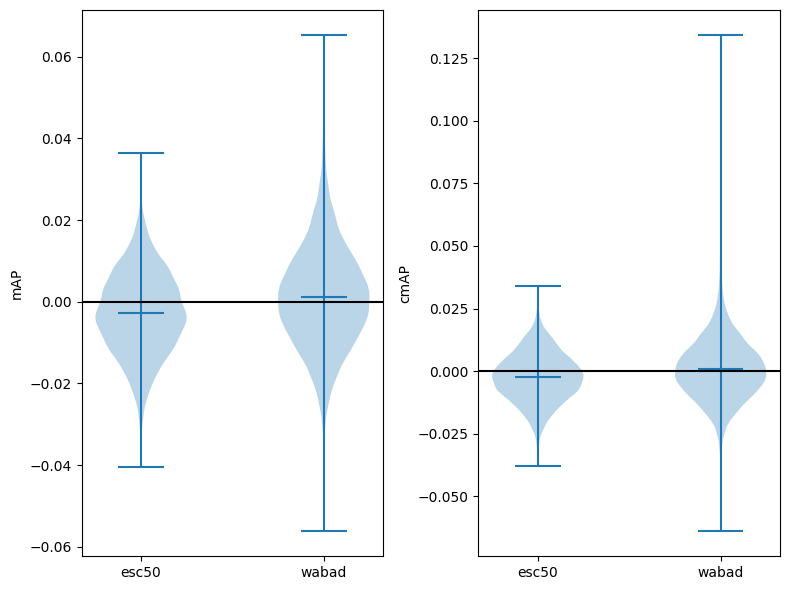

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(8,6))
labels = ["esc50", "wabad"]
ax[0].violinplot( [mAP_correlations[13453:],mAP_correlations[0:13453]] ,  showmeans=True)
ax[0].axhline(0, color ='k')
ax[0].set_xticks(np.arange(1, len(labels) + 1), labels=labels)
ax[0].set_ylabel("mAP")
ax[1].violinplot( [cmAP_correlations[13453:], cmAP_correlations[0:13453]] ,  showmeans=True)
ax[1].axhline(0, color ='k')
ax[1].set_xticks(np.arange(1, len(labels) + 1), labels=labels)
ax[1].set_ylabel("cmAP")
plt.tight_layout()

t_stat, p_value = stats.ttest_ind(mAP_correlations[13453:], mAP_correlations[0:13453] )
print(p_value)
t_stat, p_value = stats.ttest_ind(cmAP_correlations[13453:], cmAP_correlations[0:13453] )
print(p_value)


